## Import Modules

In [1]:
# Core
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

# Text Processing
import wordcloud
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk.collocations as nc
import spacy
nlp = spacy.load('en_core_web_sm')
# we should remove stopwords, including google and tesla
stops = stopwords.words('english') + ['google', 'tesla']
en_stopwords = set(stops)

# Time Series
import seaborn as sns
sns.set()



## Import Datasets 
#### (Google & Tesla reviews web-scraped from Indeed)

In [2]:
# Code Source 
# https://stackoverflow.com/questions/16888888/how-to-read-a-xlsx-file-
# using-the-pandas-library-in-ipython

df_google = pd.read_excel('google_reviews.xlsx', sheet_name="sheet1")
df_tesla = pd.read_excel('tesla_reviews.xlsx', sheet_name="sheet1")

## EDA & Data Cleaning

In [3]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial
df_google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 6 columns):
title       1326 non-null object
reviewer    1329 non-null object
location    1329 non-null object
date        1329 non-null object
rating      1329 non-null float64
reviews     1329 non-null object
dtypes: float64(1), object(5)
memory usage: 62.4+ KB


In [4]:
df_tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 6 columns):
title       1233 non-null object
reviewer    1235 non-null object
location    1235 non-null object
date        1235 non-null object
rating      1235 non-null float64
reviews     1235 non-null object
dtypes: float64(1), object(5)
memory usage: 58.0+ KB


####  Convert data types

In [5]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Date to date data type
df_google.date = pd.to_datetime(df_google.date)
# Rating to integer
df_google.rating = df_google.rating.astype(np.int64)

df_tesla.date = pd.to_datetime(df_tesla.date)
df_tesla.rating = df_tesla.rating.astype(np.int64)

In [6]:
# Take a look at the google dataframe
df_google.head(2)

,title,reviewer,location,date,rating,reviews
0,Awesome,Camp Counselor (Former Employee) –,"Northborough, MA",2018-01-17,5,Awesome stuff at google if I had to rate it fr...
1,Google is great Bon Apeptit isn’t so great!,Micro kitchen attendant (Former Employee) –,"Mountain View, CA",2018-08-24,5,Google is a great company and the googler were...


In [85]:
# Take a look at the tesla dataframe
df_tesla.head(15)

,title,location,date,rating,reviews,job_title,emp_status
0,Stressful,"Westborough, MA",2018-06-14,3,Very tight Schedule.Get to learn a little.Aver...,PV Design Engineer II,current
1,Looks good on the resume,"Burbank, CA",2019-01-16,3,Tesla asks if you're okay with overtime but yo...,Service Advisor,former
2,I love this job I want to go back,"Fremont, CA",2019-01-18,5,I love this job I would love to have another o...,Brake Line Installer,former
3,Temp Job,"Las Vegas, NV",2019-01-19,1,This by far was the worst experience of my lif...,Customer Service Representative,former
4,Great Start to Career,"Fremont, CA",2019-01-23,4,"In my 4.5 Years there, I was able to build up ...",Supervisor,former
5,slavery,"Fremont, CA",2019-01-24,4,"infinite learning possibilities, meet and work...",Maintenance Technician,former
6,Tesla,"Fremont, CA",2019-01-26,3,"A typical day at Tesla begins at 4.30 am, wher...",Engineering Equipment Maintenance Supervisor,former
7,Energetic environment - work place w/great cause,"Fremont, CA",2019-01-31,4,"extremely fast paced work environment, but fel...",Product Lifecycle Management,former
8,working for tesla,"Dallas, TX",2019-02-01,2,Tesla is not a bad company but there are a lot...,Solar Installer,current
9,Put on your blinders,"Sparks, NV",2018-12-29,3,Day by day is a fast-paced work. Get your rest...,Material Handler/Forklift Operator,former



#### Create employee type (former or current employee) from reviewer variable

In [8]:
# Strip out former/current employee and make it's own variable
# Code Source: 
# https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/

# split reviewer variable on '(' 
new_google = df_google["reviewer"].str.split("(", n = 1, expand = True) 
new_tesla = df_tesla["reviewer"].str.split("(", n = 1, expand = True) 

# make job title column from the left part of the split 
df_google["job_title"]= new_google[0] 
df_tesla["job_title"]= new_tesla[0] 
  
# make emp type column from the right part of the split
df_google["emp_status"]= new_google[1] 
df_tesla["emp_status"]= new_tesla[1] 

# Drop reviewer column 
df_google.drop('reviewer', inplace=True, axis=1)
df_tesla.drop('reviewer', inplace=True, axis=1) 

In [9]:
# Now have 7 variables, created employee type & job title, dropped reviewer
df_google.shape

(1329, 7)

In [10]:
df_tesla.shape

(1235, 7)

In [13]:
# Code Source
# https://stackoverflow.com/questions/22391433/count-the-frequency
# -that-a-value-occurs-in-a-dataframe-column

# Get a count of each employee status category
df_google['emp_status'].value_counts()



Former Employee) –                                                     826
Current Employee) –                                                    454
Contract) (Former Employee) –                                           12
Contractor) (Former Employee) –                                          6
Contract) (Current Employee) –                                           2
contract) (Current Employee) –                                           2
Operations Technician Assistant) (Former Employee) –                     1
Contract Onsite) (Former Employee) –                                     1
Full-time) (Former Employee) –                                           1
ITRP) (Current Employee) –                                               1
Google Shopping Express) (Current Employee) –                            1
ETouch) (Former Employee) –                                              1
Google Maps Team) (Former Employee) –                                    1
Tier 1) (Current Employee

In [14]:
# Get a count of each employee status category
df_tesla['emp_status'].value_counts()



Former Employee) –                                     728
Current Employee) –                                    490
Temp) (Former Employee) –                                2
Mechanical Joining) (Current Employee) –                 1
Automation) (Former Employee) –                          1
Production Associate) -Via (Current Employee) –          1
 Lead-Davie) (Former Employee) –                         1
PLM) Program Manager (Former Employee) –                 1
Contract) (Former Employee) –                            1
Production Control /Model 3) (Current Employee) –        1
Paint) (Former Employee) –                               1
Full-time) (Current Employee) –                          1
Supply Chain Programs (Current Employee) –               1
CDL) (Current Employee) –                                1
Powertrain Conveyance) (Current Employee) –              1
SEASONAL) (Former Employee) –                            1
contract) (Former Employee) –                           

In [15]:
# Code source from Text Analytics Week 6 at Regis with Dr. Nathan George

# Received an error, found resolution here:
# https://www.reddit.com/r/learnpython/comments/4siyaf/error_while
# _removing_the_punctuations_in_a_string/

# Strip punctuation from emp type
table = str.maketrans({key: None for key in string.punctuation})
df_google["emp_status"] = [str(d).translate(table) for d in df_google["emp_status"]]
df_tesla["emp_status"] = [str(d).translate(table) for d in df_tesla["emp_status"]]

# just pay attention to performance, dask or swiftapply, parallel processing



In [16]:
# Code Source
# https://stackoverflow.com/questions/18196203/
# how-to-conditionally-update-dataframe-column-in-pandas

# Pretty much an if statement - if emp_status contains 'Current', make it 'current', else make it 'former'
df_google['emp_status'] = np.where(df_google['emp_status'].str.contains('Current'), 'current', 'former')

df_tesla['emp_status'] = np.where(df_tesla['emp_status'].str.contains('Current'), 'current', 'former')

# No need to strip the punctuation - just comment it out if on github - will track versions, collaborate with others
# SVN - like github, not used as much, older version



In [17]:
df_google.head(2)

,title,location,date,rating,reviews,job_title,emp_status
0,Awesome,"Northborough, MA",2018-01-17,5,Awesome stuff at google if I had to rate it fr...,Camp Counselor,former
1,Google is great Bon Apeptit isn’t so great!,"Mountain View, CA",2018-08-24,5,Google is a great company and the googler were...,Micro kitchen attendant,former


#### Explore newly created employee status variable

In [18]:
df_google['emp_status'].value_counts()


former     863
current    466
Name: emp_status, dtype: int64

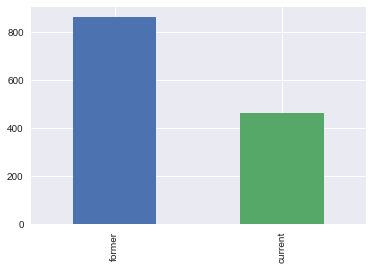

In [19]:
# Emp Status Frequency Bar Plot Google
# Code Source
# https://etav.github.io/python/count_basic_freq_plot.html

### This fixes the kernel dying problem
### https://stackoverflow.com/questions/47022997/jupyter-the-kernel-appears-to-have-
### died-it-will-restart-automatically

df_google['emp_status'].value_counts().plot('bar')

In [21]:
df_tesla['emp_status'].value_counts()


former     738
current    497
Name: emp_status, dtype: int64

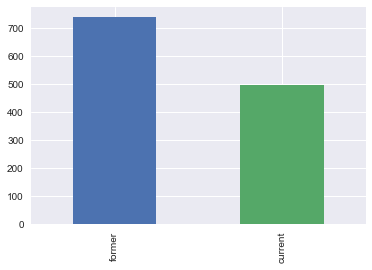

In [22]:
# Emp Status Frequency Bar Plot Tesla
df_tesla['emp_status'].value_counts().plot('bar')

# Percentages - both in 1 charge, stacked bars to add up to 1

#### Explore rating variable

In [23]:
# Look at Rating Summary for Google
df_google['rating'].describe()

count    1329.000000
mean        4.221971
std         0.999065
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

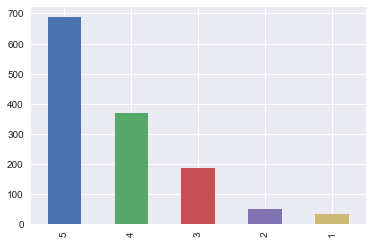

In [24]:
# Rating Frequency Bar Plot Google
df_google['rating'].value_counts().plot('bar')

# remove colors

In [25]:
# Look at Rating Summary for Tesla
df_tesla['rating'].describe()

count    1235.000000
mean        3.587854
std         1.277285
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

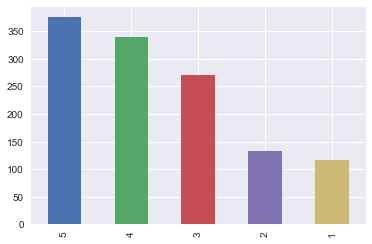

In [26]:
# Rating Frequency Bar Plot Google
df_tesla['rating'].value_counts().plot('bar')

#### TF-IDF


In [27]:
# Combine title and reviews to clean for each review
google_review_text = df_google["title"] + ' ' + df_google["reviews"]
tesla_review_text = df_tesla["title"] + ' ' + df_tesla["reviews"]


In [28]:
google_review_text[1]

'Google is great Bon Apeptit isn’t so great! Google is a great company and the googler were awesome, knowledgeable and open to teaching. It was the company I was contacted with Bon Apeptit that was terrible the management was u professional much like being on highschool. Not much room for advancement unless you were related to someone that worked there. I worked there for a year only revived a 2% increase in my raise so after a year in a half I was at 15.30. I felt like I was treated poorly by management there. As well as my health and safety while working was put at risk'

In [29]:
tesla_review_text[1]

"Looks good on the resume Tesla asks if you're okay with overtime but you don't realize you're giving up all your personal time. As a service advisor, you start your day writing tickets and interacting with customers. Throughout the day, you need to keep up with updating customers three times a day while stuck on the drive. Management sets expectations that aren't feasible and focus on the customer service index that you don't always have control over (the customers not filling out the survey or deleting them). It was difficult to balance the work load and a personal life with the amount of time it takes to keep customers in the loop."

In [30]:
# Code from Week 6 Solution - Regis Text Analytics Class - Dr. Nathan George
def preprocess_text(text_docs):
   
    # remove punctuation
    table = str.maketrans({key: None for key in string.punctuation})
    docs = [str(d).translate(table) for d in text_docs]
    # replace newlines with spaces
    docs = [re.sub('[\r\n]+', ' ', d) for d in docs]
    # replace website links with space -- want to do this before digits
    docs = [re.sub('https[\w]*', ' ', d) for d in docs]
    # replace digits with space
    docs = [re.sub('\d', ' ', d) for d in docs]
    # relpace multiple spaces with one
    docs = [re.sub('\s\s+', ' ', d) for d in docs]
    # process with spacy
    spacy_docs = [nlp(d) for d in docs]
    docs = []
    for d in spacy_docs:  # each document
        temp_doc = []
        for w in d:  # each word in a document
            # remove stopwords and numbers
            if w.lemma_ in en_stopwords or w.lemma_.isdigit():
                continue  # goes back to beginnig of loop
            elif w.lemma_ != '-PRON-':
                temp_doc.append(w.lower_)
        
        docs.append(' '.join(temp_doc))
    
    return docs

In [31]:
# Run preprocess_text for reviews
cln_review_google = preprocess_text(google_review_text)
cln_review_tesla = preprocess_text(tesla_review_text)

In [32]:
cln_review_google[1]

'great bon apeptit great great company googler awesome knowledgeable open teaching company contacted bon apeptit terrible management u professional much like highschool much room advancement unless related someone worked worked year revived increase raise year half felt like treated poorly management well health safety working put risk'

In [33]:
cln_review_tesla[1]

'looks good resume asks okay overtime realize giving personal time service advisor start day writing tickets interacting customers throughout day need keep updating customers three times day stuck drive management sets expectations feasible focus customer service index always control customers filling survey deleting difficult balance work load personal life amount time takes keep customers loop'

In [34]:
# Code from Week 4 Solution - Regis Text Analytics Class - Dr. Nathan George

# min_df=3 ignores terms occuring in less than 3 documents

# Instantiate tfidf vectorizer and fit_transform
tfidf_vectorizer_google = TfidfVectorizer(min_df=3)
train_tfidf_vectors_google = tfidf_vectorizer_google.fit_transform(cln_review_google)

tfidf_vectorizer_tesla = TfidfVectorizer(min_df=3)
train_tfidf_vectors_tesla = tfidf_vectorizer_tesla.fit_transform(cln_review_tesla)

In [35]:
train_tfidf_vectors_google.shape

(1329, 1791)

In [36]:
train_tfidf_vectors_tesla.shape

(1235, 1795)

In [37]:
wc = wordcloud.WordCloud(width=800, height=400)

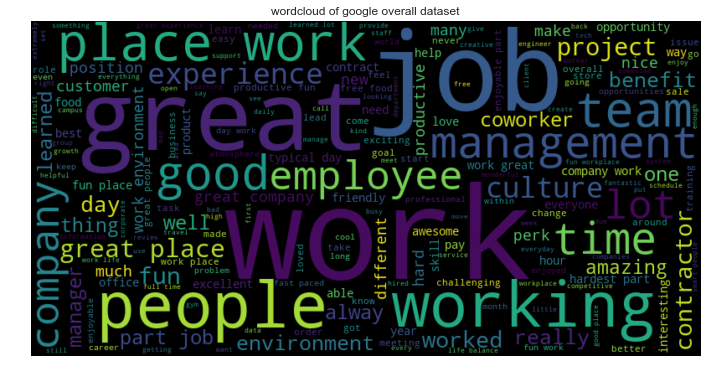

In [39]:
cloud_google = wc.generate_from_text(' '.join(cln_review_google))
_ = plt.figure(figsize=(12, 12))
plt.imshow(cloud_google, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.title('wordcloud of google overall dataset')

# two works - word cloud argument - say just use 1 gram 2 gram

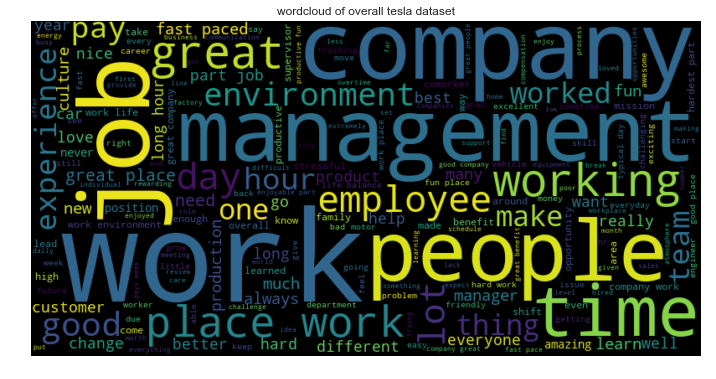

In [41]:
cloud_tesla = wc.generate_from_text(' '.join(cln_review_tesla))
_ = plt.figure(figsize=(12, 12))
plt.imshow(cloud_tesla, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.title('wordcloud of overall tesla dataset')

In [42]:
# Code from Week 6 Solution - Regis Text Analytics Class - Dr. Nathan George

# Count Vectorizer Google

cv_google = CountVectorizer()
counts_google = cv_google.fit_transform([r for r in cln_review_google])

word_counts_google = np.sum(counts_google.toarray(), axis=0)  # get total counts for each word

sorted_idx_google = np.argsort(word_counts_google)[::-1]  # greatest counts to least

top_words_google = word_counts_google[sorted_idx_google]

vocab_google = {i: w for w, i in cv_google.vocabulary_.items()}  # reverse word: index dictionary

top = 20
for v, c in zip(top_words_google[:top], [vocab_google[i] for i in sorted_idx_google][:top]):
    print(v, c)

1393 work
915 great
535 place
523 job
442 company
428 people
392 working
391 fun
334 good
295 environment
269 management
266 day
254 time
252 team
235 part
235 experience
221 culture
203 would
196 lot
186 get


In [43]:
# Count Vectorizer Tesla 

cv_tesla = CountVectorizer()

counts_tesla = cv_tesla.fit_transform([r for r in cln_review_tesla])

word_counts_tesla = np.sum(counts_tesla.toarray(), axis=0)  # get total counts for each word

sorted_idx_tesla = np.argsort(word_counts_tesla)[::-1]  # greatest counts to least

top_words_tesla = word_counts_tesla[sorted_idx_tesla]

vocab_tesla = {i: w for w, i in cv_tesla.vocabulary_.items()}  # reverse word: index dictionary

top = 20
for v, c in zip(top_words_tesla[:top], [vocab_tesla[i] for i in sorted_idx_tesla][:top]):
    print(v, c)

1388 work
633 company
632 great
512 job
471 place
401 good
387 working
377 management
373 people
272 day
264 environment
262 hours
248 time
231 get
222 would
221 fast
214 fun
194 lot
193 like
190 employees


## Time Series

In [44]:
# Code Source
# https://stackoverflow.com/questions/22391433/
# count-the-frequency-that-a-value-occurs-in-a-dataframe-column

# Value counts by date
df_date_count_google = df_google['date'].value_counts()
df_date_count_tesla = df_tesla['date'].value_counts()


In [45]:
# Save as a dataframe
df_date_google = pd.DataFrame(df_date_count_google)
df_date_tesla = pd.DataFrame(df_date_count_tesla)

In [46]:
# Code Source
# https://stackoverflow.com/questions/26097916/
# convert-pandas-series-to-dataframe

# reset and name index, rename columns
df_count_google = df_date_google.date.to_frame().reset_index()
df_count_google = df_count_google.rename(columns= {'index': 'date', 'date': 'count' })
df_count_google.index.name = 'index'

df_count_tesla = df_date_tesla.date.to_frame().reset_index()
df_count_tesla = df_count_tesla.rename(columns= {'index': 'date', 'date': 'count' })
df_count_tesla.index.name = 'index'


In [47]:
df_count_google.head(2)

,date,count
index,,
0,2018-06-27,6
1,2017-08-31,6


In [48]:
# Code Source - # https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Set date as the index for time series plots
df_count_google.set_index('date', inplace=True)
df_count_tesla.set_index('date', inplace=True)

In [51]:
df_count_google.head(2)

,count
date,
2018-06-27,6
2017-08-31,6


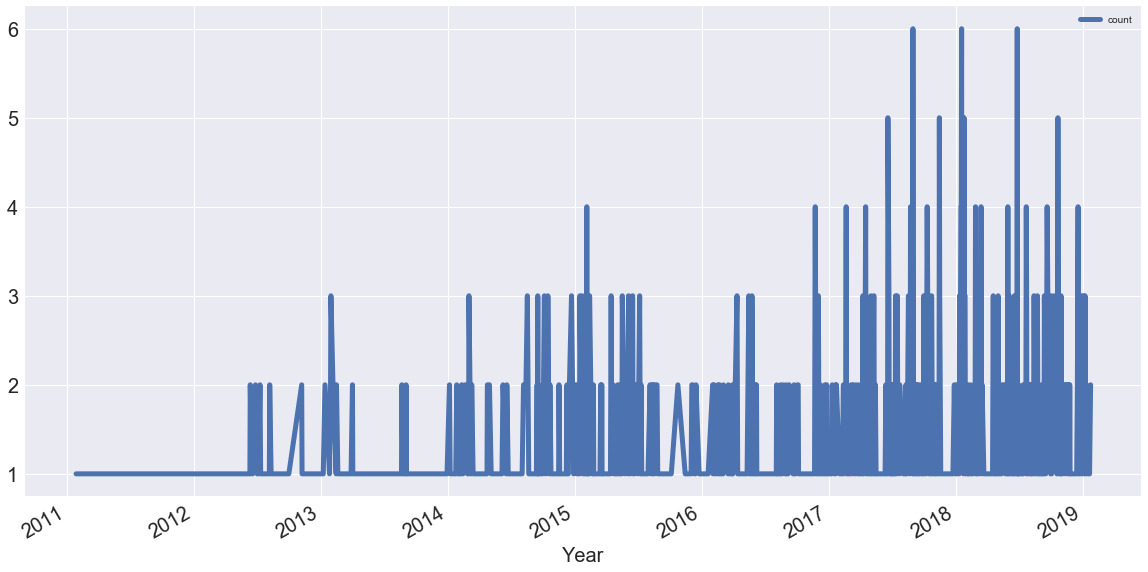

In [52]:
# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Plot time series google - add labels
df_count_google.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);

# Going to have to drop the outlier

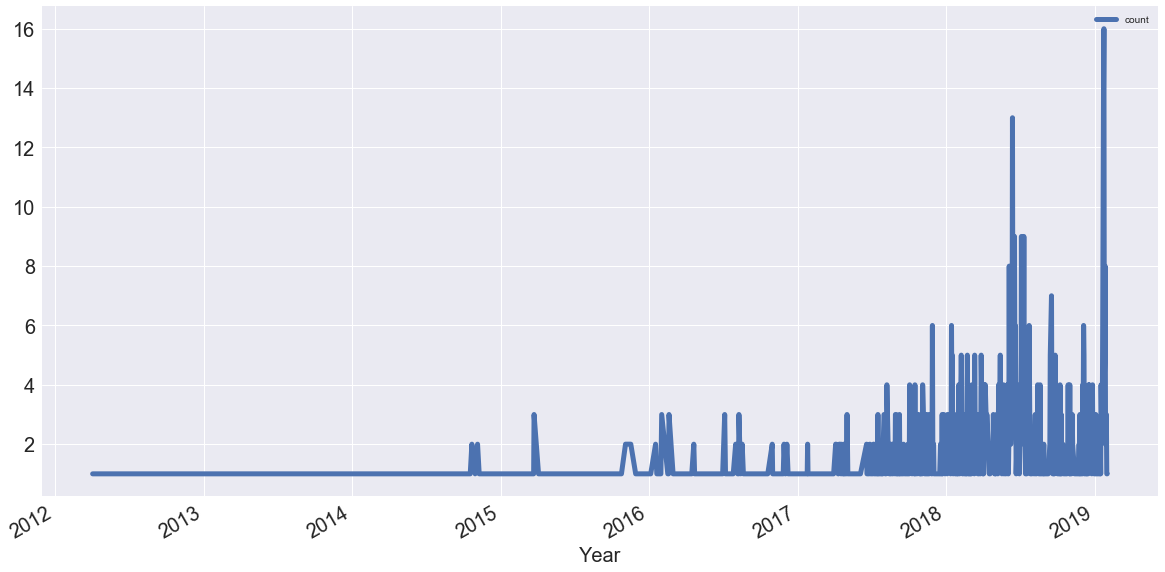

In [53]:
# Plot time series tesla - add labels
df_count_tesla.plot(figsize=(20,10),linewidth = 5,fontsize=20)
plt.xlabel('Year',fontsize=20);

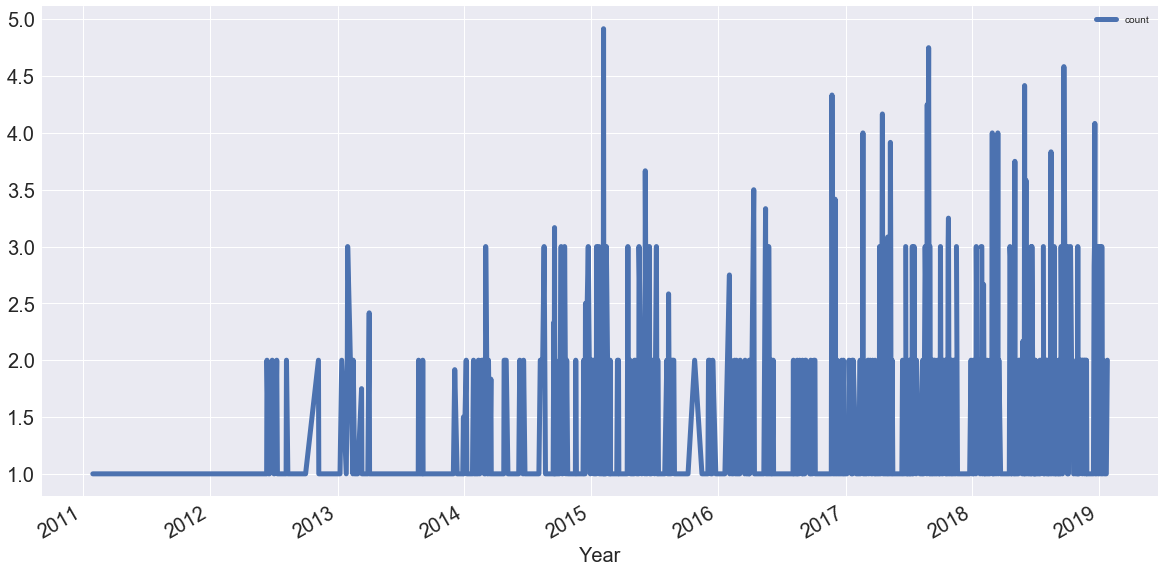

In [54]:
# Code Source - 
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Plot time series rolling mean google - add labels
df_count_google.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

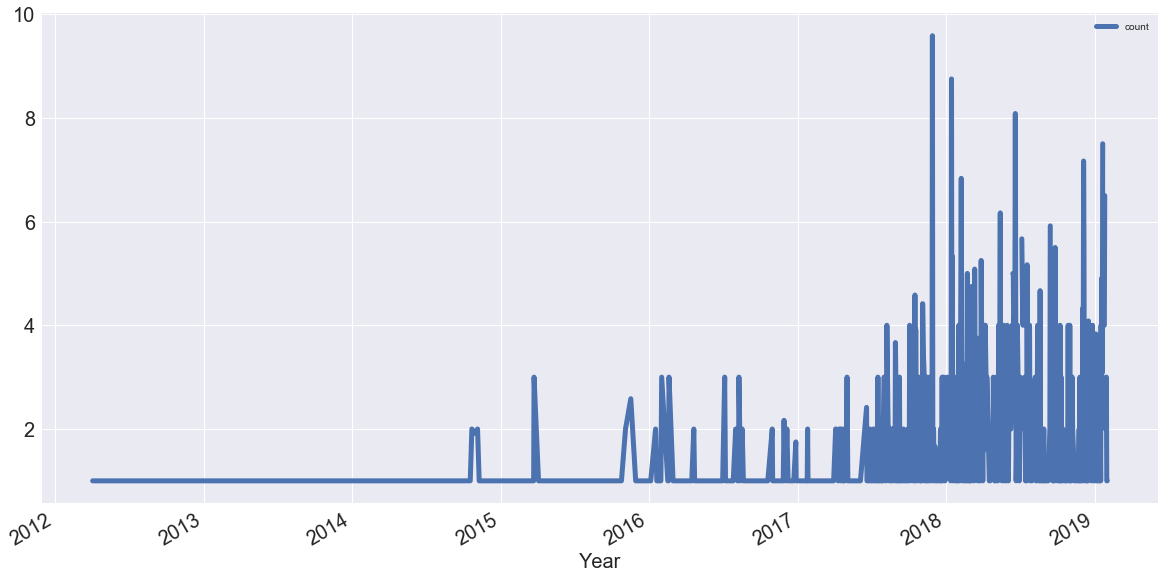

In [55]:
# Plot time series rolling mean tesla - add labels
df_count_tesla.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

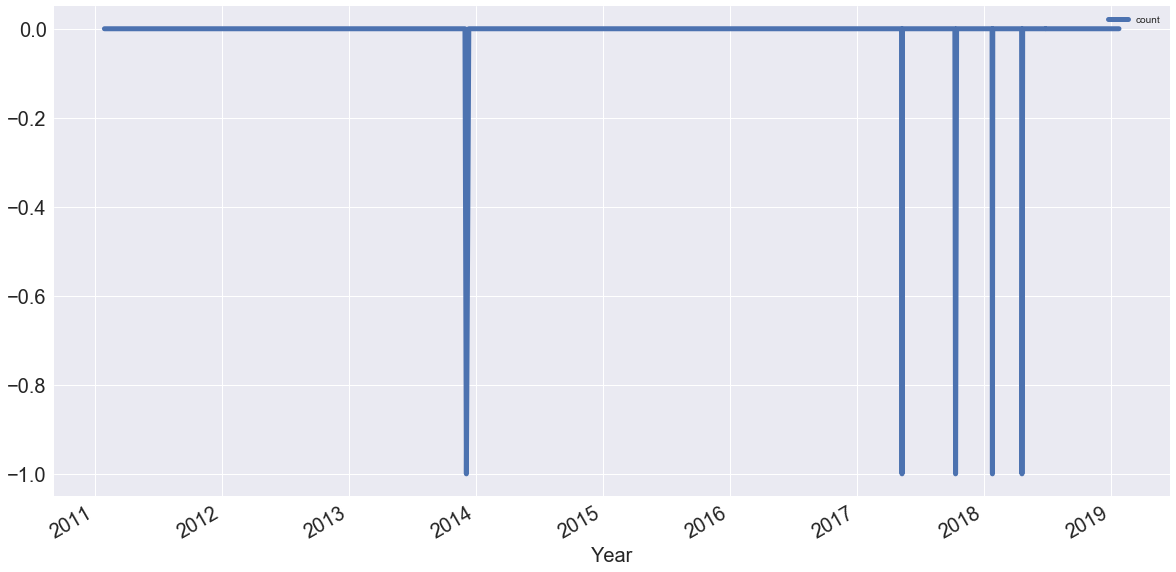

In [56]:
# Code Source
# https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial

# Plot time series diff to remove trend google - add labels
df_count_google.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

# Not looking right - should see more here - probably may not need this
# Look at via month and day of week
# make test set and try out - np array same and numby diff

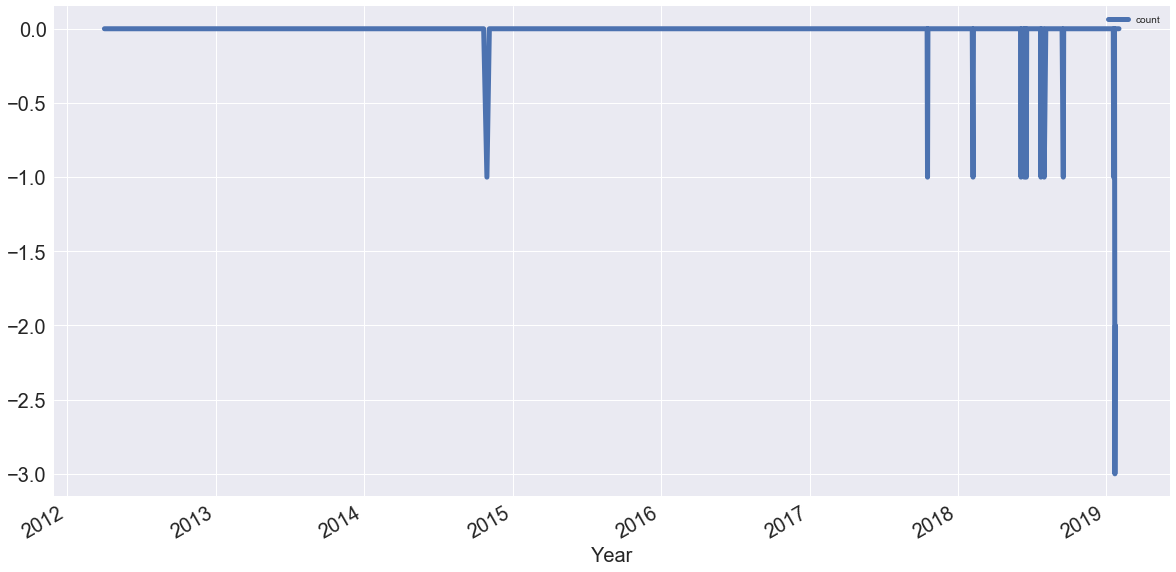

In [57]:
# Plot time series diff to remove trend tesla - add labels
df_count_tesla.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

## GEO

In [ ]:
# Geo - https://www.datacamp.com/community/tutorials/geospatial-data-python
# Avg sentiment/rating by location - map as a visual - folium - interactive

In [ ]:
from mpl_toolkits.basemap import Basemap

## Supervised Learning on Ratings or Sentiment - parameter tuning

In [58]:
# Code Source
# DataCamp course supervised learning with SciKit Learn

df_google_emp_status = pd.get_dummies(df_google['emp_status'])

In [59]:
df_google.head(2)

,title,location,date,rating,reviews,job_title,emp_status
0,Awesome,"Northborough, MA",2018-01-17,5,Awesome stuff at google if I had to rate it fr...,Camp Counselor,former
1,Google is great Bon Apeptit isn’t so great!,"Mountain View, CA",2018-08-24,5,Google is a great company and the googler were...,Micro kitchen attendant,former


In [107]:
df_google_sup = df_google_emp_status["current"] + df_google['rating']
google_review_text = df_google["title"] + ' ' + df_google["reviews"]

In [60]:
df_google_trimmed = pd.DataFrame([df_google.location,df_google.rating]).transpose()

In [79]:
# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas

df_tfidf = pd.DataFrame(train_tfidf_vectors_google.toarray())

In [83]:
df_google_sl = pd.concat([df_google_emp_status, df_google_trimmed,df_tfidf], axis=1, ignore_index=True) 
df_google_sl_renamed = df_google_sl.rename(columns= {0: 'current', 1: 'former', 2: 'location', 3: 'rating' })


In [84]:
df_google_sl_renamed.head(2)

# Should I use something like PCA for feature reduction?
# Better to do sentiment analysis and predict sentiment (binary classification) or multiclass and predict rating?

# Topic Modeling - lda, lsa - useful - take action
# Words - make pick up some words that are not in sentiment - extract the most popular words

# densify tfidf vector - take top 100 words - use min freq to get certain number of dimensions - max features 
# - tfidf documentation

# way to look at most important words - look this up - forest methods.  random forest - feature importance

,current,former,location,rating,4,5,6,7,8,9,...,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794
0,0,1,"Northborough, MA",5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,"Mountain View, CA",5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.286478,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
df_google['job_title'].value_counts()

BI Developer                                           87
Store Operator                                         43
Program Manager                                        22
Ads Quality Rater                                      15
Test Engineer                                          12
Project Manager                                        12
Visual Data Specialist                                 12
Operations Lead                                        11
Software Engineer                                      10
Software Engineering Intern                             9
Customer Service Representative                         9
Field Operations Associate                              9
Contractor                                              9
Field Operations Specialist                             8
Operations Assembler                                    8
Warehouse Associate                                     8
Operations Specialist                                   8
Administrative

In [102]:
df_google['location'].value_counts()

# Need to clean up this data - all over the place, may not be useful

Mountain View, CA                      658
New York, NY                           122
Atlanta, GA                             52
Austin, TX                              47
Sunnyvale, CA                           44
San Jose, CA                            38
San Francisco, CA                       33
Bothell, WA                             30
Ann Arbor, MI                           29
Pittsburgh, PA                          26
Kirkland, WA                            22
Chicago, IL                             21
Los Angeles, CA                         21
Council Bluffs, IA                      18
Cambridge, MA                           18
Kansas City, MO                         18
Seattle, WA                             16
Palo Alto, CA                           16
Mountain View                           14
Tempe, AZ                               13
California                              13
Remote                                  12
Miami, FL                               11
Washington,

## N grams

## Sentiment Analysis

In [ ]:
# LSA or LDA easier in R - save tfidf in python - load into R and run LDA and LSA.
# Graphlab - nice library for topic models, try first in python - activate license

## Unsupervised Learning - Topics Gathering - parameter tuning